# Cuaderno explicativo del Reto_02: Creacion Modelo predictivo de Calidad del Aire

A continuación se muestra el Pipeline que seguiremos para crear el modelo.

Hay que tener en cuenta lo siguiente:

* Para modelos clasicos tipo ARMA, ARIMA, SARIMA... :
    * El pipeline es practicamente el mismo, tras estudiar la tendencia, estacionalidad y estacionariedad de la seríe debemos eliminar tendencia y estacionalidad para obtener una serie con una Media y Varianza casi constantes, lo que mejoraria la prediccion de esta.
* Para aplicar métodos de Machine Learning (SVM, XGBoost...) y Deep Learning (Redes neuronales, Redes LSTM...):
    * No es de vital importancia eliminar la tendencia y estacionalidad, ni siquiera la serie debe ser estacionaria para poder entrenar el modelo.
    * En este caso lo mejor es crear más variables a partir de los datos brutos que tenemos, dichas variables pueden ser medias, medias deslizantes, dividir la fecha en 2 variables mas (mes y dia), etc
    * Es decir, la solución es **Transformar nuestro problema en un problema de regresión supervisada** esto se consigue transformando la Serie Temporal -> DataSet preparado (que incluye lags, medias deslizantes, diferencias...)

**Documentación**
> Tratamiento Series Temporales (Clasico): https://github.com/ayrna/ap2324

> Documentacion H2O: https://github.com/h2oai/h2o-3/tree/master/h2o-docs

> https://h2o.ai/blog/2019/a-deep-dive-into-h2os-automl/

> Ejemplos de uso oficiales: https://github.com/h2oai/h2o-3/tree/master/h2o-py/demos

> Ejemplo de uso AutoML H2O en Series Temporales: https://github.com/SeanPLeary/time-series-h2o-automl-example/blob/master/h2o_automl_example_with_multivariate_time_series.ipynb


> Test ADF https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller_aumentada

> Test ADF https://www.linkedin.com/advice/0/how-do-you-interpret-results-augmented-dickey-fuller?lang=es&lang=es&originalSubdomain=es

> https://www.geeksforgeeks.org/automl-using-h2o/


Además se adjuntan los documentos "H2O_R_Python_Parity.md" y "Python_H2OFrame_PandasDataFrame_Parity.md" como cheatsheet de H2O


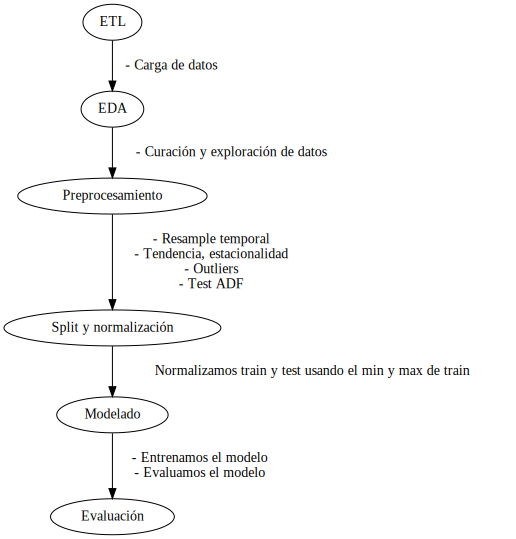

In [7]:
from graphviz import Digraph

# Crea un objeto Digraph
dot = Digraph()

# Añade nodos con información adicional
dot.node('A', 'ETL')
dot.node('B', 'EDA')
dot.node('C', 'Preprocesamiento')
dot.node('D', 'Split y normalización')
dot.node('E', 'Modelado')
dot.node('F', 'Evaluación')

# Añade aristas con información adicional
dot.edge('A', 'B', label='- Carga de datos')
dot.edge('B', 'C', label='- Curación y exploración de datos')
dot.edge('C', 'D', label='- Resample temporal \n- Tendencia, estacionalidad \n- Outliers \n- Test ADF')
dot.edge('D', 'E', label='Normalizamos train y test usando el min y max de train')
dot.edge('E', 'F', label='- Entrenamos el modelo \n- Evaluamos el modelo')

# Muestra el diagrama
dot

In [6]:
from crate import client
import pandas as pd
import h2o
import matplotlib.pyplot as plt

HOST_CRATE='http://localhost:4200'
HOST_H2O='http://localhost:54321'


## 1. ETL (Extract, Transform and Load)

ETL es un proceso que se utiliza para integrar datos de múltiples fuentes en un solo sistema. El proceso ETL funciona en tres pasos: extracción de los datos relevantes de la base de datos de origen, transformación de los datos para que sean más adecuados para el análisis y carga de los datos en el sistema de destino. 


Vamos a conectarnos a CrateDB, realizamos una consulta y descargamos los datos.

In [7]:
def query_to_dataframe(crate_host, query, username="crate"):
    """
    Ejecuta una consulta en CrateDB y devuelve los resultados como un DataFrame de pandas.

    :param crate_host: Dirección del servidor CrateDB (por ejemplo, "http://localhost:4200/")
    :param query: Consulta SQL a ejecutar
    :param username: Usuario para la conexión (por defecto "crate")
    :return: pandas DataFrame con los resultados de la consulta
    """
    try:
        # Conexión a CrateDB
        connection = client.connect(crate_host, username=username)
        cursor = connection.cursor()

        # Ejecutar la consulta
        cursor.execute(query)

        # Obtener las columnas de la consulta
        columns = [col[0] for col in cursor.description]

        # Obtener los resultados de la consulta
        data = cursor.fetchall()

        # Convertir los resultados a un DataFrame de pandas
        df = pd.DataFrame(data, columns=columns)

        # Cerrar la conexión
        cursor.close()
        connection.close()

        return df

    except Exception as e:
        print("Error en la consulta:", e)
        return None

In [8]:
# Conexion con CrateDB para descargar los datos
connection = client.connect("localhost:4200")
cursor = connection.cursor()

# Consulta para obtener los datos de la estación COCOR_LEPANTO
query= """ 
SELECT entity_id, time_index, no2, so2, o3, pm10, pm25
FROM "mtatdfiware"."etestacion_meteo"
WHERE entity_id LIKE 'COCOR_LEPANTO' """ # Esta consulta es la misma que hacemos en el portal de crate para buscar cierta tabla, en este ejemplo vamos a trabajar con los datos de COCOR_LEPANTO
cursor.execute(query)

# Obtener las columnas de la consulta
df=query_to_dataframe(HOST_CRATE, query,"crate")

# Pasamos time_index a formato datetime
df["time_index"]=pd.to_datetime(df["time_index"],unit="ms")
# ordenamos de mas antiguo a mas reciente
df.sort_values("time_index", inplace=True)

print(df.head(49),"\n") # 49 registros porque debe haber 2 dias completos (24 instancias para cada dia) y un registro mas para el dia actual
print("Dimension df:", df.shape,"\n")
print("Tipos de datos de las columnas:\n",df.dtypes)
print("\nValores nulos por columna:\n",df.isnull().sum())



# Ponemos la columna del tiempo como indice
df.set_index("time_index", inplace=True)

# Lo hacemos al final para ver si tenemos huecos en blanco en el tiempo

           entity_id          time_index   no2  so2      o3    pm10    pm25
26464  COCOR_LEPANTO 2021-10-25 01:00:00  41.0  5.0  54.125  26.362   9.833
26465  COCOR_LEPANTO 2021-10-25 02:00:00  25.0  5.0  45.000  26.362   9.875
26466  COCOR_LEPANTO 2021-10-25 03:00:00  17.0  5.0  37.875  26.552  10.000
19390  COCOR_LEPANTO 2021-10-25 04:00:00  11.0  5.0  34.000  26.505  10.125
19391  COCOR_LEPANTO 2021-10-25 05:00:00  10.0  5.0  32.500  26.268  10.125
26467  COCOR_LEPANTO 2021-10-25 06:00:00  11.0  4.0  30.625  26.078  10.167
7306   COCOR_LEPANTO 2021-10-25 07:00:00   9.0  5.0  33.000  25.935  10.125
26468  COCOR_LEPANTO 2021-10-25 08:00:00  11.0  5.0  34.125  25.888  10.125
7307   COCOR_LEPANTO 2021-10-25 09:00:00  17.0  5.0  35.000  25.745  10.083
5048   COCOR_LEPANTO 2021-10-25 10:00:00  19.0  5.0  35.000  25.840  10.083
5049   COCOR_LEPANTO 2021-10-25 11:00:00  14.0  5.0  34.375  26.125  10.042
5050   COCOR_LEPANTO 2021-10-25 12:00:00  11.0  6.0  34.875  26.030  10.000
26469  COCOR

```python
Valores nulos por columna:
entity_id      0
time_index     0
no2          448
so2          864
o3           279
pm10         247
pm25         269
dtype: int64
```



Debemos primero rellenar estos huecos en blanco

In [9]:
# Interpolamos mediante spline para rellenar los huecos en blanco
df.interpolate(method="spline", order=2, inplace=True)

print("\nValores nulos por columna:\n",df.isnull().sum())

print("=====================================================\nDescripcion:\n",df.describe())

/tmp/ipykernel_13976/2673520148.py:2: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="spline", order=2, inplace=True)



Valores nulos por columna:
 entity_id    0
no2          0
so2          0
o3           0
pm10         0
pm25         0
dtype: int64
Descripcion:
                 no2           so2            o3          pm10          pm25
count  28571.000000  28571.000000  28571.000000  28571.000000  28571.000000
mean      14.671096      2.406758     54.638677     26.537384     11.955602
std       13.111186      0.797509     29.107163     20.286144      6.309278
min      -20.660745      0.000000    -17.256031      2.796000      1.197000
25%        6.000000      2.000000     31.375000     16.588000      7.800000
50%       10.000000      2.000000     53.078000     23.130000     10.865000
75%       19.000000      3.000000     75.429000     31.556566     15.040000
max      102.000000     18.000000    142.125000    552.568000    115.375000


## 2. EDA (Exploratory Data Analysis)

EDA es un método que se utiliza para analizar y resumir conjuntos de datos. Los científicos de datos lo utilizan para analizar e investigar conjuntos de datos y resumir sus principales características, empleando a menudo métodos de visualización de datos.

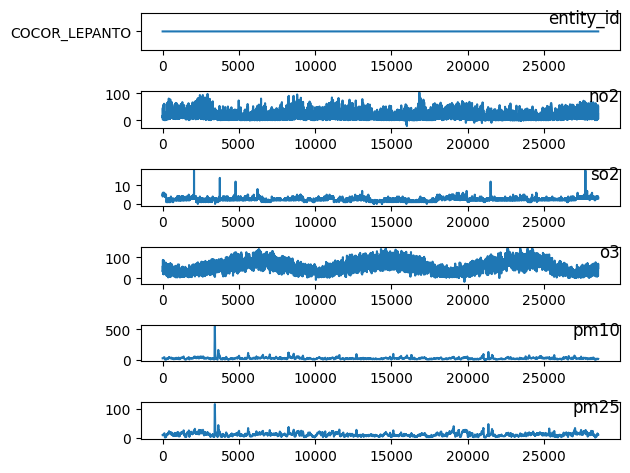

Descripcion:
                 no2           so2            o3          pm10          pm25
count  28571.000000  28571.000000  28571.000000  28571.000000  28571.000000
mean      14.671096      2.406758     54.638677     26.537384     11.955602
std       13.111186      0.797509     29.107163     20.286144      6.309278
min      -20.660745      0.000000    -17.256031      2.796000      1.197000
25%        6.000000      2.000000     31.375000     16.588000      7.800000
50%       10.000000      2.000000     53.078000     23.130000     10.865000
75%       19.000000      3.000000     75.429000     31.556566     15.040000
max      102.000000     18.000000    142.125000    552.568000    115.375000
Correlación entre las variables:
            no2       so2        o3      pm10      pm25
no2   1.000000  0.223184 -0.299925  0.086891  0.233345
so2   0.223184  1.000000 -0.172459  0.069719  0.256517
o3   -0.299925 -0.172459  1.000000 -0.011198 -0.201459
pm10  0.086891  0.069719 -0.011198  1.000000  0.

In [10]:
import matplotlib.pyplot as plt

def plot_columns(df, groups):
    """
    Grafica las columnas especificadas de un DataFrame.

    Args:
    df (pd.DataFrame): DataFrame que contiene los datos.
    groups (list): Lista de índices de columnas que deseas graficar.

    Returns:
    None
    """
    values = df.values  # Asegúrate de que 'df' sea tu DataFrame

    plt.figure()
    for i, group in enumerate(groups, start=1):
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.5, loc='right')

    plt.tight_layout()
    plt.show()

# Ejemplo de uso
# Supongamos que 'df' es tu DataFrame y 'groups' es la lista de índices de columnas
plot_columns(df, [0, 1, 2, 3, 4, 5])

dff=df.drop(columns=["entity_id"])
print("===================\nDescripcion:\n",df.describe())
print("===================\nCorrelación entre las variables:\n",dff.corr())

Viendo las correlaciones de las variables, concluimos que lo mejore es crear:
* 1 Modelo_NO2 basado en los datos historicos del NO2
* 1 Modelo_SO2 basado en los datos historicos del SO2
* 1 Modelo_O3 basado en los datos historicos del O3
* 1 Modelo_PM10 basado en los datos historicos del PM10 y PM25
* 1 Modelo_PM25 basado en los datos historicos del PM25 y PM10


Si la correlacion entre las variables fuera mas alta (>0'8) como en el caso de pm10 y pm25 entonces meteriamos esas variables en los modelos correspondientes


# OZONO (O3)

El primer modelo que vamos a crear es para el Ozono, pues a simple vista parece que es el que tiene una distribución menos caotica y posiblemente obtengamos resultados aceptables.


Vamos a aplicar tecnicas de ML y DL asi que no es necesario corregir tendencia, estacionalidad y hacer la serie estacionaria. Pero aun asi vamos a realizar un estudio de estas caracteristicas de la serie.

In [12]:
# Extraemos un df con los datos del o3
o3=df["o3"]
print(o3.head(24))

time_index
2021-10-25 01:00:00    54.125
2021-10-25 02:00:00    45.000
2021-10-25 03:00:00    37.875
2021-10-25 04:00:00    34.000
2021-10-25 05:00:00    32.500
2021-10-25 06:00:00    30.625
2021-10-25 07:00:00    33.000
2021-10-25 08:00:00    34.125
2021-10-25 09:00:00    35.000
2021-10-25 10:00:00    35.000
2021-10-25 11:00:00    34.375
2021-10-25 12:00:00    34.875
2021-10-25 13:00:00    37.750
2021-10-25 14:00:00    43.500
2021-10-25 15:00:00    50.125
2021-10-25 16:00:00    58.250
2021-10-25 17:00:00    67.750
2021-10-25 18:00:00    77.250
2021-10-25 19:00:00    85.250
2021-10-25 20:00:00    86.875
2021-10-25 21:00:00    83.375
2021-10-25 22:00:00    82.250
2021-10-25 23:00:00    73.500
2021-10-26 00:00:00    64.750
Name: o3, dtype: float64


Resample por D:
 time_index
2021-10-25    51.581522
2021-10-26    45.864583
2021-10-27    50.010417
2021-10-28    47.458333
2021-10-29    44.546458
Freq: D, Name: o3, dtype: float64
Media Deslizante (ventana de 720):
 time_index
2021-10-25 01:00:00   NaN
2021-10-25 02:00:00   NaN
2021-10-25 03:00:00   NaN
2021-10-25 04:00:00   NaN
2021-10-25 05:00:00   NaN
2021-10-25 06:00:00   NaN
2021-10-25 07:00:00   NaN
2021-10-25 08:00:00   NaN
2021-10-25 09:00:00   NaN
2021-10-25 10:00:00   NaN
Name: o3, dtype: float64


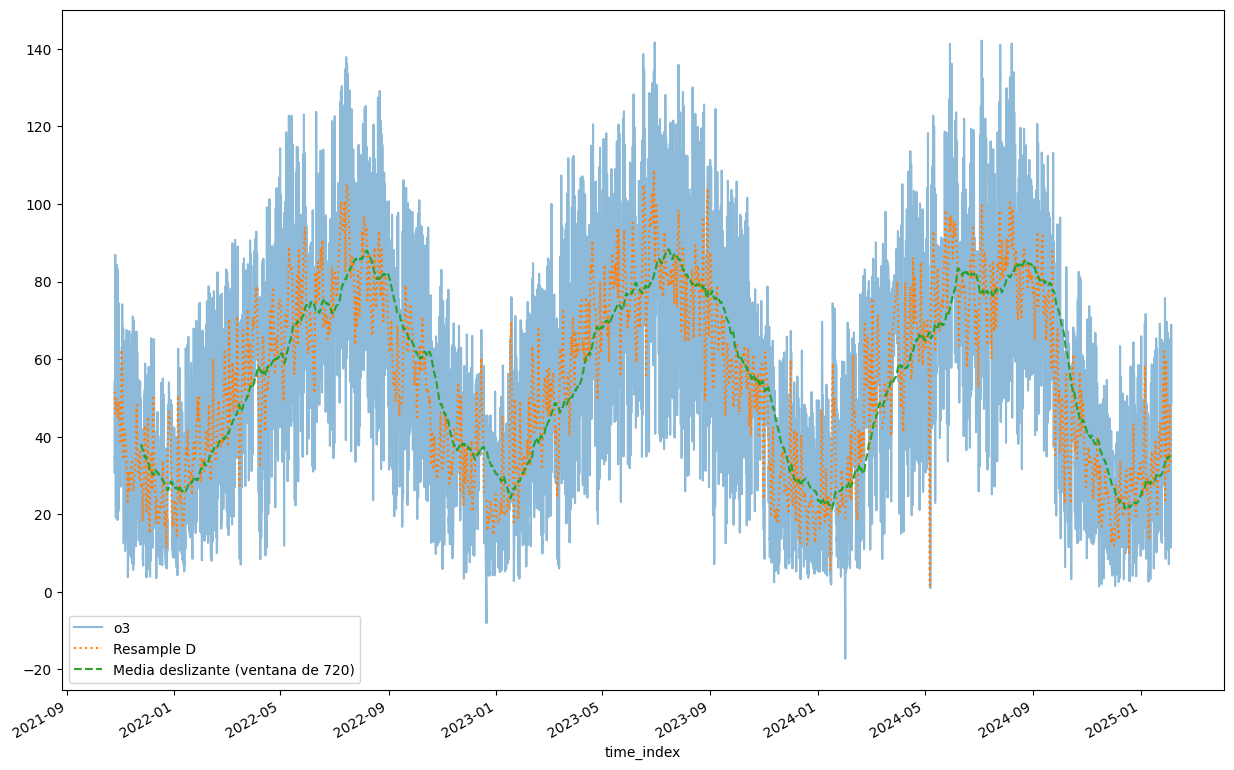

In [13]:
"""
RESAMPLE: Cambia la frecuencia de la serie temporal y añade una funcion de agregacion (.sum(), .mean(), .std(), .count(), etc)

ROLLING: Calcula una estadística móvil (como la media o la suma) a lo largo de una ventana de tiempo fija, de forma predeterminada si la ventana es de
x elementos, se calcula la media de esos x elementos, y se desplaza un elemento hacia adelante para calcular la media de los siguientes x elementos.
tiene un parametro que es CENTER que si es True, el valor de la ventana se coloca en el centro de la ventana, si es False, el valor de la ventana se coloca en el extremo derecho de la ventana.
"""

def resample_and_plot(df, resample_freq='D', rolling_window=720):
    """
    Resamplea una serie temporal y calcula la media deslizante, luego visualiza los datos.

    Args:
    df (pd.Series): Serie temporal con un índice de fecha y hora.
    resample_freq (str): Frecuencia de resampleo (por defecto 'D' para días).
    rolling_window (int): Tamaño de la ventana para la media deslizante (por defecto 720).

    Returns:
    None
    """
    # Resampleamos por la frecuencia especificada
    df_resample = df.resample(resample_freq).mean()
    print(f"Resample por {resample_freq}:\n", df_resample.head())

    # Calculamos la media deslizante
    df_roll = df.rolling(window=rolling_window).mean()
    print(f"Media Deslizante (ventana de {rolling_window}):\n", df_roll.head(10))

    # Visualizamos los datos resampleados con su media deslizante
    ax = df.plot(alpha=0.5, style='-', figsize=(15, 10))  # guardamos los ejes para reutilizarlos
    df_resample.plot(style=':', ax=ax, label=f'Resample {resample_freq}')
    df_roll.plot(style='--', ax=ax, label=f'Media deslizante (ventana de {rolling_window})')
    ax.legend()
    plt.show()
    return df_resample

# Ejemplo de uso
# Supongamos que 'o3' es tu serie temporal
o3_resample=resample_and_plot(o3, resample_freq='D', rolling_window=720)

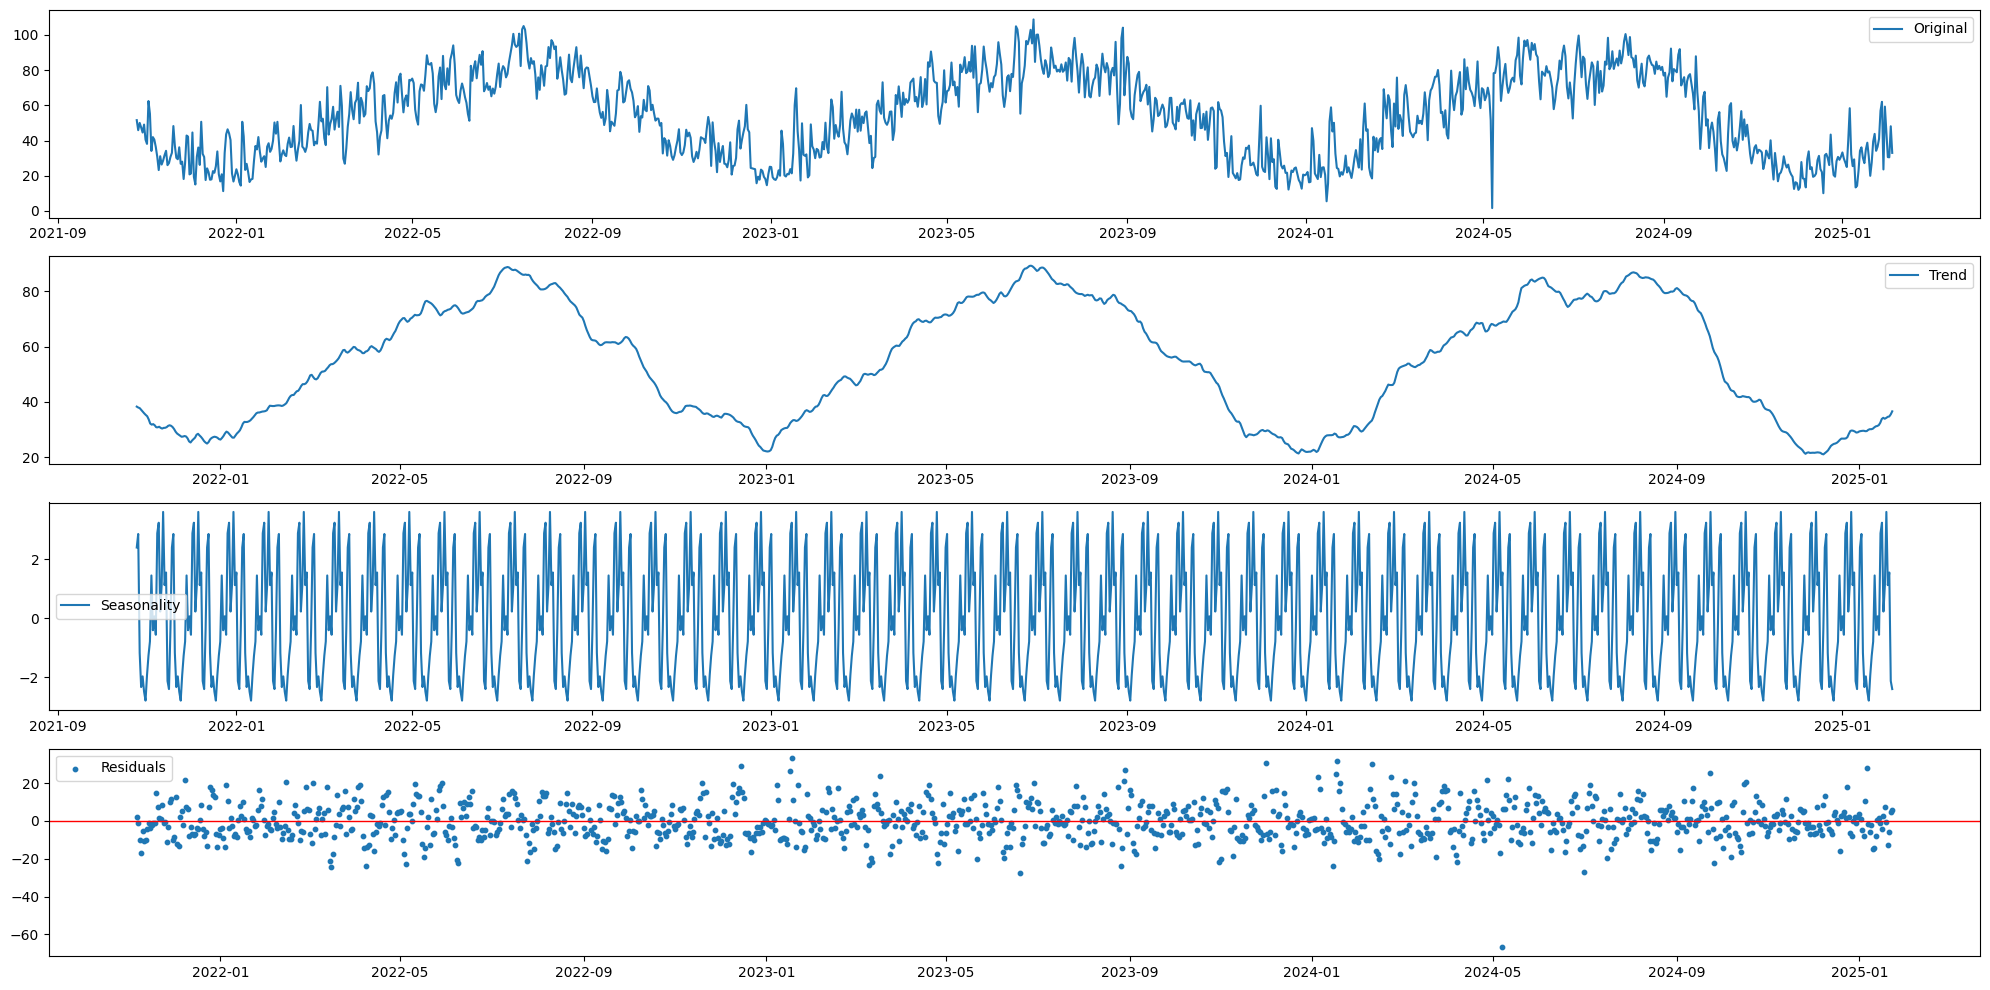

In [14]:
###############################################
# TENDENCIA - ESTACIONALIDAD - RESIDUOS
###############################################
from statsmodels.tsa.seasonal import seasonal_decompose

def decompose_and_plot(serie_temporal, freq='D', period=24):
    """
    Descompone una serie temporal en tendencia, estacionalidad y residuos, y visualiza los componentes.

    Args:
    serie_temporal (pd.Series): Serie temporal con un índice de fecha y hora.
    freq (str): Frecuencia de resampleo (por defecto 'D' para días).
    period (int): Período para la descomposición estacional (por defecto 24).

    Returns:
    dict: Diccionario con los componentes de la descomposición (tendencia, estacionalidad, residuos).
    """
    # Interpolación y ajuste de frecuencia
    
    x = serie_temporal.interpolate(method="linear", order=2)
    x.index = pd.to_datetime(x.index)
    x = x.astype(float)  # Asegurarse de que los datos sean de tipo float
    x = x.asfreq(freq)  # Ajustar la frecuencia a la especificada

    # Descomposición estacional
    decomposition = seasonal_decompose(x, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Visualización de los componentes
    fig, axes = plt.subplots(4, 1, figsize=(20, 10))
    axes[0].plot(x, label='Original')
    axes[0].legend(loc='best')
    axes[1].plot(trend, label='Trend')
    axes[1].legend(loc='best')
    axes[2].plot(seasonal, label='Seasonality')
    axes[2].legend(loc='best')
    axes[3].scatter(residual.index, residual, label='Residuals', s=10)
    axes[3].axhline(0, color='red', linestyle='-', linewidth=1)  # Línea en cero
    axes[3].legend(loc='best')
    plt.tight_layout()
    plt.show()

    return {'trend': trend, 'seasonal': seasonal, 'residual': residual}

# Ejemplo de uso
# Supongamos que 'o3_resample' es tu Serie temporal resampleada
components = decompose_and_plot(o3_resample, freq='D', period=24)

En este punto ya hemos visto de forma visual y directa las distintas componentes de nuestra serie temporal, afinando los resamples podemos obtener curvas más suaves (aunque por el camino perderemos informacion)


Como vamos a realizar un estudio basado en un Modelo ML/DL no hace falta eliminar estas componentes, aun así a continuacion se muestran ciertas herramientas

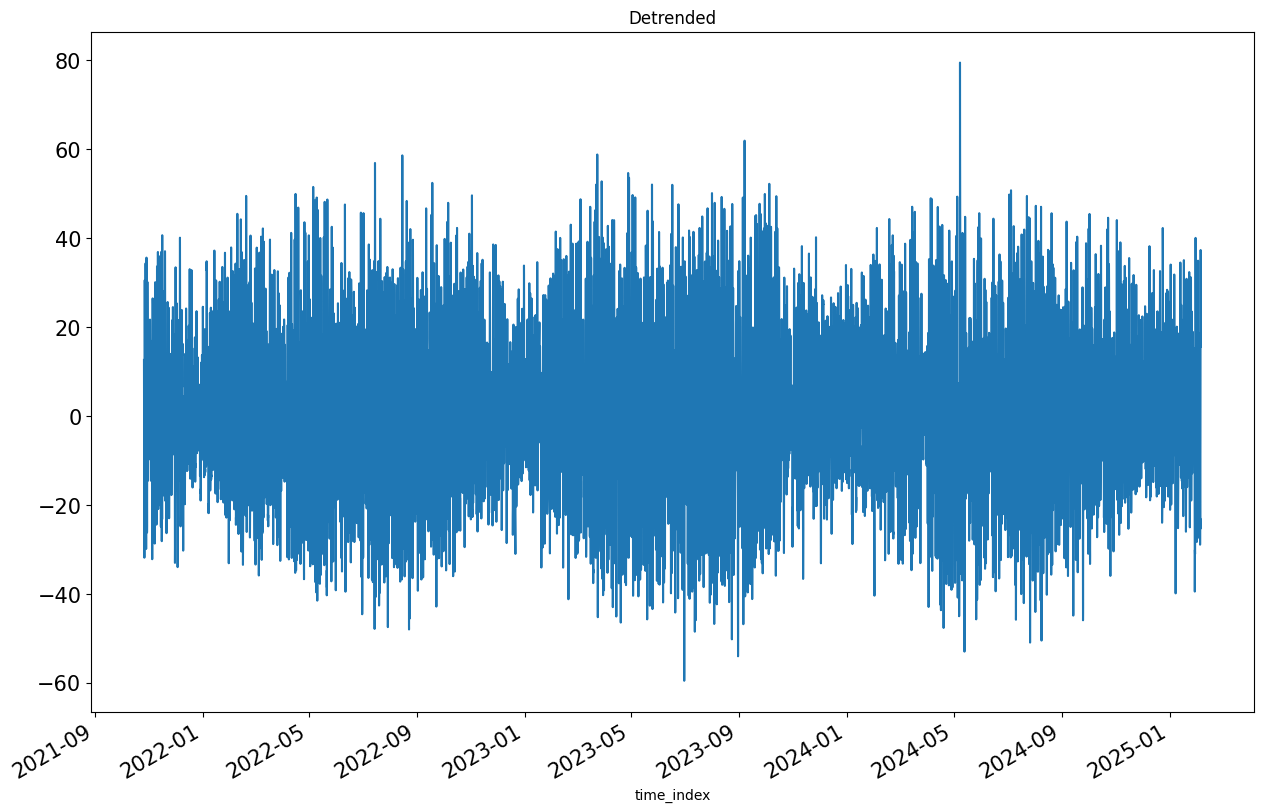

In [15]:
################################
# Eliminamos tendencia de la serie
################################


def detrend_and_plot(df, rolling_window=24):
    """
    Elimina la tendencia de una serie temporal utilizando una media deslizante y visualiza los datos.

    Args:
    o3 (pd.Series): Serie temporal con un índice de fecha y hora.
    rolling_window (int): Tamaño de la ventana para la media deslizante (por defecto 24).

    Returns:
    None
    """
    # Calculamos la media deslizante
    df_roll = df.rolling(window=rolling_window).mean()

    # Eliminamos la tendencia de la serie
    df_detrended = df - df_roll

    # Dibujamos la serie sin tendencia
    df_detrended.plot(figsize=(15, 10), linewidth=1.5, fontsize=15, title='Detrended')
    plt.show()

    return df_detrended

df_detrended = detrend_and_plot(o3, rolling_window=24)

### ADF Test


> https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller_aumentada

> https://www.linkedin.com/advice/0/how-do-you-interpret-results-augmented-dickey-fuller?lang=es&lang=es&originalSubdomain=es

Me he dado cuenta de que este ADF_test falla para grandes volumenes de datos como es este caso, aun asi podemos usar test_stationarity para ver de forma visual la media y varianza, nuestro objetivo es **Conseguir una media y varianza lo mas constante posible**

In [17]:
# Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

def ADF_test(timeseries, dataDesc):
    """
    Realiza la prueba de Dickey-Fuller Aumentada (ADF) para verificar la estacionariedad de una serie temporal.

    Parámetros:
    timeseries (pd.Series): Serie temporal a analizar.
    dataDesc (str): Descripción de la serie temporal.

    Imprime:
    - Estadístico de la prueba ADF.
    - Valor p de la prueba ADF.
    - Valores críticos para diferentes niveles de confianza.
    """
    print(' > ¿Es estacionaria la serie {}?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Estadístico = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Valores críticos :')
    for k, v in dftest[4].items():
        print('\t{}: {} - La serie es {} estacionaria con una confianza de {}%'.format(k, v, 'no' if v<dftest[0] else '', 100-int(k[:-1])))

def test_stationarity(timeseries, title, window=24):
    """
    Representa los estadísticos para comprobar la estacionariedad de una serie temporal.

    Parámetros:
    timeseries (pd.Series): Serie temporal a analizar.
    title (str): Título del gráfico.
    window (int): Ventana para el cálculo de la media y desviación estándar deslizante. Por defecto es 24.

    Genera:
    - Un gráfico que muestra la serie temporal original, la media deslizante y la desviación estándar deslizante.
    """
    # Determinar los estadísticos
    rolmean = pd.Series(timeseries).rolling(window=window).mean() 
    rolstd = pd.Series(timeseries).rolling(window=window).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='media deslizante')
    ax.plot(rolstd, label='desviación típica deslizante (x'+str(window)+')')
    ax.legend()

Con estos dos test vemos la estacionariedad de la serie.

El primero es un test de contraste de hipotesis (ADF) basado en el valor de un estadistico.
Cuando tenemos muchisimos datos en nuestra serie temporal y algo caoticos es posible que el p-valor tienda a cero, o que el valor del estadistico tienda a +- infinito.

**NOTA: RECHAZAR LA HIPOTESIS NULA NO SIGNIFICA QUE DEBAMOS ACEPTARLA COMO VERDADERA LA HIPOTESIS ALTERNATIVA** 

El otro test muestra de una manera visual la media y varianza de la serie.



> **Bonus:** http://tankona.free.fr/fisher1935.pdf      (Más información sobre Test de Hipotesis, conceptos, metodología...)

 > ¿Es estacionaria la serie Original?
Estadístico = -6.817
P-value = 0.000
Valores críticos :
	1%: -3.4305793088592944 - La serie es  estacionaria con una confianza de 99%
	5%: -2.86164134812435 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5668239445474152 - La serie es  estacionaria con una confianza de 90%


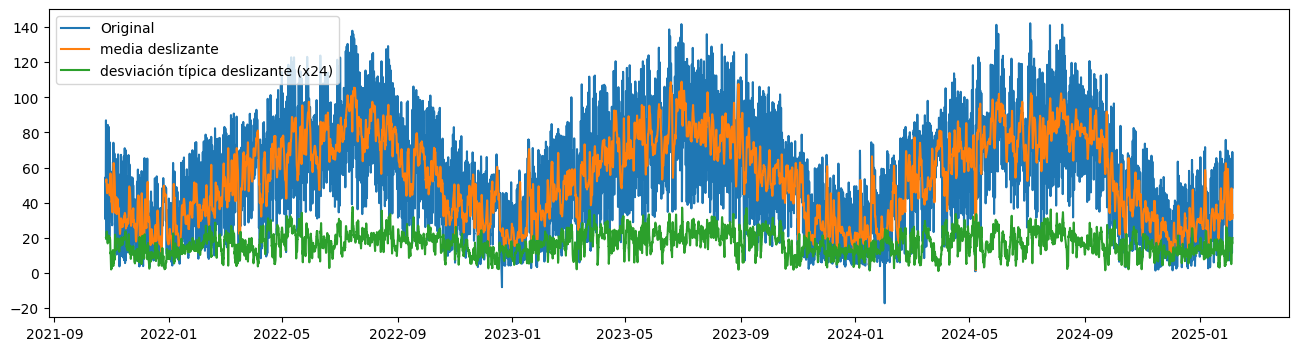

In [18]:
# ORIGINAL
ADF_test(o3, "Original")
test_stationarity(o3, "Original")

 > ¿Es estacionaria la serie Detrended?
Estadístico = -30.363
P-value = 0.000
Valores críticos :
	1%: -3.430579493951724 - La serie es  estacionaria con una confianza de 99%
	5%: -2.8616414299268818 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5668239880889843 - La serie es  estacionaria con una confianza de 90%


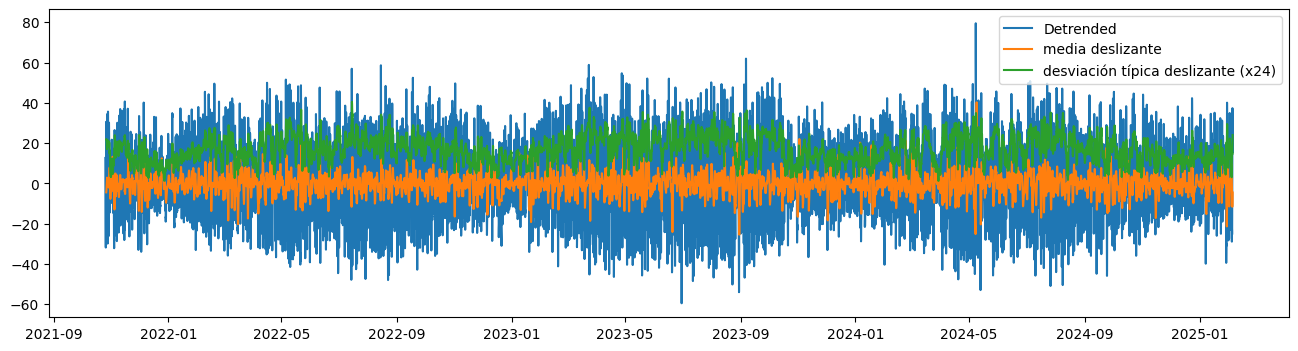

In [19]:
# Sin TENDENCIA
#
o3_de=(o3 - o3.rolling(window=24).mean())
ADF_test(o3_de, "Detrended")
test_stationarity(o3_de, "Detrended")

 > ¿Es estacionaria la serie Detrended?
Estadístico = -30.324
P-value = 0.000
Valores críticos :
	1%: -3.430579493951724 - La serie es  estacionaria con una confianza de 99%
	5%: -2.8616414299268818 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5668239880889843 - La serie es  estacionaria con una confianza de 90%


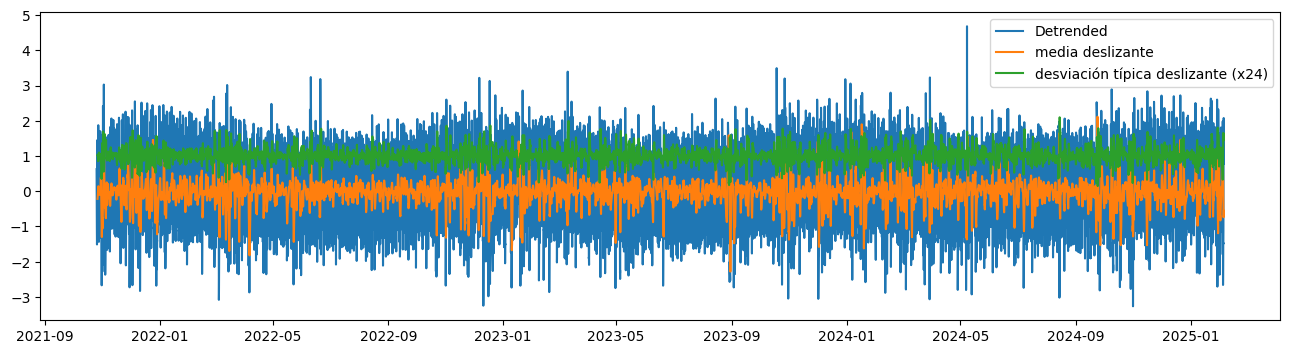

In [20]:
# TIPIFICADA

o3_de=(o3 - o3.rolling(window=24).mean())/o3.rolling(window=24).std()


ADF_test(o3_de, "Detrended")
test_stationarity(o3_de, "Detrended")   

**NOTA: TODAS ESTAS TRANSFORMACIONES HAY QUE HACERLAS DE FORMA QUE GUARDEMOS DICHOS PARAMETROS PARA DESPUES REVERTIRLAS**


A continuacion mostramos una forma de hacerlo:

### Ejemplo Transformación

In [16]:
import pandas as pd

# Supongamos que 'o3' es tu Serie de pandas con un índice de fecha y hora
o3.index = pd.to_datetime(o3.index)

# Calcular la media móvil y la desviación estándar móvil
rolling_mean = o3.rolling(window=24).mean()
rolling_std = o3.rolling(window=24).std()

# Aplicar la transformación
o3_de = (o3 - rolling_mean) / rolling_std

# Guardar los parámetros
rolling_params = pd.DataFrame({'mean': rolling_mean, 'std': rolling_std})

# Mostrar la serie transformada y los parámetros
print("Serie transformada:\n", o3_de.head(48))
print("Parámetros de la transformación:\n", rolling_params.head(48))

Serie transformada:
 time_index
2021-10-25 01:00:00         NaN
2021-10-25 02:00:00         NaN
2021-10-25 03:00:00         NaN
2021-10-25 04:00:00         NaN
2021-10-25 05:00:00         NaN
2021-10-25 06:00:00         NaN
2021-10-25 07:00:00         NaN
2021-10-25 08:00:00         NaN
2021-10-25 09:00:00         NaN
2021-10-25 10:00:00         NaN
2021-10-25 11:00:00         NaN
2021-10-25 12:00:00         NaN
2021-10-25 13:00:00         NaN
2021-10-25 14:00:00         NaN
2021-10-25 15:00:00         NaN
2021-10-25 16:00:00         NaN
2021-10-25 17:00:00         NaN
2021-10-25 18:00:00         NaN
2021-10-25 19:00:00         NaN
2021-10-25 20:00:00         NaN
2021-10-25 21:00:00         NaN
2021-10-25 22:00:00         NaN
2021-10-25 23:00:00         NaN
2021-10-26 00:00:00    0.626719
2021-10-26 01:00:00    0.241575
2021-10-26 02:00:00   -0.098707
2021-10-26 03:00:00   -0.538977
2021-10-26 04:00:00   -0.693491
2021-10-26 05:00:00   -0.704551
2021-10-26 06:00:00   -0.994652
2021-10-

In [18]:
# Deshacer la transformación
o3_original = (o3_de * rolling_params['std']) + rolling_params['mean']

# Mostrar la serie original recuperada
print("Serie original recuperada:\n", o3_original.head(48))

print("Serie original:\n", o3.head(48))

Serie original recuperada:
 time_index
2021-10-25 01:00:00       NaN
2021-10-25 02:00:00       NaN
2021-10-25 03:00:00       NaN
2021-10-25 04:00:00       NaN
2021-10-25 05:00:00       NaN
2021-10-25 06:00:00       NaN
2021-10-25 07:00:00       NaN
2021-10-25 08:00:00       NaN
2021-10-25 09:00:00       NaN
2021-10-25 10:00:00       NaN
2021-10-25 11:00:00       NaN
2021-10-25 12:00:00       NaN
2021-10-25 13:00:00       NaN
2021-10-25 14:00:00       NaN
2021-10-25 15:00:00       NaN
2021-10-25 16:00:00       NaN
2021-10-25 17:00:00       NaN
2021-10-25 18:00:00       NaN
2021-10-25 19:00:00       NaN
2021-10-25 20:00:00       NaN
2021-10-25 21:00:00       NaN
2021-10-25 22:00:00       NaN
2021-10-25 23:00:00       NaN
2021-10-26 00:00:00    64.750
2021-10-26 01:00:00    57.125
2021-10-26 02:00:00    50.500
2021-10-26 03:00:00    41.875
2021-10-26 04:00:00    39.125
2021-10-26 05:00:00    39.375
2021-10-26 06:00:00    34.000
2021-10-26 07:00:00    33.000
2021-10-26 08:00:00    29.875
2

**Nota:** Como hemos usado una ventana deslizante de 1 día (rolling(24)) al recuperar los datos, solo podemos recuperar los datos a partir del dato 25. Es decir, perdemos los datos de las primeras 24h.

In [17]:
import matplotlib.pyplot as plt
# Visualizar las series originales y recuperadas
plt.figure(figsize=(15, 10))
plt.plot(o3-o3_original, label='Diferencia')
plt.legend()
plt.show()

print("El margen de error medio es:", (o3-o3_original).mean())
print("La desviación estándar del error es:", (o3-o3_original).std())
print("El error máximo es:", (o3-o3_original).max()- (o3-o3_original).min())

NameError: name 'o3_original' is not defined

<Figure size 1500x1000 with 0 Axes>

El grafico de arriba deberia ser cte=0, pero como se observa algunos datos no los recuperamos correctamente, aunque el margen de error es del orden de $10^{-14}$ luego no hace falta ni tenerlo en cuenta.

## 3. Preprocesamiento

Como la estrategia a seguir es entrenar un modelo de ML/DL debemos añadir valor a nuestros datos para que el modelo pueda "aprender" más facilmente.

Dichas variables normalmente son:
* Valores Lagged: esto es, valores anteriores de la variable dependiente, para que el modelo tenga noción de temporalidad.
* Variables temporales: Es bueno añadir variables que hagan referencia al mes o día de los datos, para que el modelo cree relaciones temporales.
* Medias deslizantes: Valores medios de los datos anteriores pueden ayudar al modelo a ser más preciso en sus predicciones.

A partir de este punto podemos añadir otras variables, tantas como nuestro ingenio e imaginacion nos de, pero teniendo en cuenta que hay una **linea muy fina** entre resumir información y tener un dataset consistente y sin ruido o tener un dataset con variables inutiles y con ruido innecesario.

In [24]:
# Partimos del dataframe original
final_df=o3.copy().to_frame()

def procesamiento(df):
    """
    Procesa la serie temporal 'df' añadiendo columnas de valores lagged, media móvil,
    diferencias, y variables temporales.

    Args:
    o3 (pd.Series): Serie temporal con un índice de fecha y hora.

    Returns:
    pd.DataFrame: DataFrame procesado con las nuevas columnas.
    """
    final_df = df.copy().to_frame()

    # Añadimos 5 columnas con los valores lagged de las últimas 5 horas
    for i in range(1, 6):
        final_df["x_lag_" + str(i)] = df.shift(i)

    # Añadimos una columna con la media móvil de las últimas 24h
    final_df["x_rmean_24"] = df.rolling(window=24).mean()

    # Añadimos una columna con las diferencias entre xn y xn+1
    final_df["x_diff1"] = df.diff(1)  # Esto aproxima la derivada de la serie por Newton-Raphson f'=f(x)-f(x-1)/(x-(x-1))

    # Añadimos una columna con las diferencias entre xn y xn+24
    final_df["x_diff24f"] = df.diff(-24)

    # Añadimos una columna con el valor de o3 de las proximas 24h, para predecir el valor de o3 en 24h
    final_df["x_next24"]=df.shift(-24)

    # Añadimos una columna con la media de las proximas 24h
    final_df["x_rmean_24f"] = df.shift(-24).rolling(window=24).mean()

    # Añadimos columnas referente al mes y al día de la semana de la instancia
    final_df["year"] = df.index.year
    final_df["year"]=final_df["year"].astype(int)
    final_df["month"] = df.index.month
    final_df["month"]=final_df["month"].astype(int)
    final_df["dayofweek"] = df.index.dayofweek
    final_df["dayofweek"]=final_df["dayofweek"].astype(int)
    final_df["hour"] = df.index.hour
    final_df["hour"]=final_df["hour"].astype(int)
    final_df["date"] = df.index.date

    # Eliminamos los valores NaN (con esto perdemos los primeros 24 datos, que como tenemos tantos días no es relevante)
    final_df.dropna(inplace=True)

    return final_df
final_df = procesamiento(o3)

final_df.head(48)

,o3,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24f,x_next24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,,
2021-10-26 00:00:00,64.750,73.500,82.250,83.375,86.875,85.250,52.130208,-8.750,3.500,61.250,45.718750,2021,10,1,0,2021-10-26
2021-10-26 01:00:00,57.125,64.750,73.500,82.250,83.375,86.875,52.255208,-7.625,4.750,52.375,45.520833,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,50.500,57.125,64.750,73.500,82.250,83.375,52.484375,-6.625,3.750,46.750,45.364583,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,41.875,50.500,57.125,64.750,73.500,82.250,52.651042,-8.625,-0.500,42.375,45.385417,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,39.125,41.875,50.500,57.125,64.750,73.500,52.864583,-2.750,-3.875,43.000,45.546875,2021,10,1,4,2021-10-26
2021-10-26 05:00:00,39.375,39.125,41.875,50.500,57.125,64.750,53.151042,0.250,-0.875,40.250,45.583333,2021,10,1,5,2021-10-26
2021-10-26 06:00:00,34.000,39.375,39.125,41.875,50.500,57.125,53.291667,-5.375,-8.000,42.000,45.916667,2021,10,1,6,2021-10-26
2021-10-26 07:00:00,33.000,34.000,39.375,39.125,41.875,50.500,53.291667,-1.000,-4.500,37.500,46.104167,2021,10,1,7,2021-10-26
2021-10-26 08:00:00,29.875,33.000,34.000,39.375,39.125,41.875,53.114583,-3.125,-4.500,34.375,46.291667,2021,10,1,8,2021-10-26


Vamos a ver la correlación de las variables introducidas con las demás. Esta es una forma de ver si las nuevas variables meten o no ruido.
Cuando la correlación es casi cero, entonces esa variable va a tener muy poco efecto o un efecto casi nulo en nuestro modelo.

In [25]:
f=final_df.drop(columns=["date"])
f.corr()

,o3,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24f,x_next24,x_rmean_24f,year,month,dayofweek,hour
o3,1.000000,0.984806,0.942802,0.879083,0.800209,0.713304,0.769415,0.087139,0.262263,0.862078,0.762141,0.042442,-0.086909,0.030442,0.274051
x_lag_1,0.984806,1.000000,0.984805,0.942805,0.879088,0.800216,0.776363,-0.087185,0.259565,0.848303,0.754982,0.042302,-0.086344,0.030918,0.205800
x_lag_2,0.942802,0.984805,1.000000,0.984806,0.942809,0.879095,0.782847,-0.240970,0.248958,0.811878,0.748108,0.042150,-0.085779,0.031352,0.115546
x_lag_3,0.879083,0.942805,0.984806,1.000000,0.984807,0.942811,0.788727,-0.365556,0.232519,0.756805,0.741692,0.042002,-0.085235,0.031701,0.007739
x_lag_4,0.800209,0.879088,0.942809,0.984807,1.000000,0.984808,0.793906,-0.452509,0.212143,0.688646,0.735836,0.041854,-0.084718,0.031857,-0.108767
x_lag_5,0.713304,0.800216,0.879095,0.942811,0.984808,1.000000,0.798335,-0.498588,0.189585,0.613604,0.730603,0.041717,-0.084242,0.031655,-0.221759
x_rmean_24,0.769415,0.776363,0.782847,0.788727,0.793906,0.798335,1.000000,-0.039872,0.162081,0.684149,0.897224,0.051447,-0.102830,0.024830,0.000033
x_diff1,0.087139,-0.087185,-0.240970,-0.365556,-0.452509,-0.498588,-0.039872,1.000000,0.015472,0.078997,0.041053,0.000800,-0.003239,-0.002731,0.391518
x_diff24f,0.262263,0.259565,0.248958,0.232519,0.212143,0.189585,0.162081,0.015472,1.000000,-0.262946,-0.014207,-0.003081,0.018798,0.025015,-0.001471
x_next24,0.862078,0.848303,0.811878,0.756805,0.688646,0.613604,0.684149,0.078997,-0.262946,1.000000,0.769456,0.044052,-0.096764,0.017300,0.274771


Esta es la forma final que tendra nuestro dataset para entrenar y testear.

Como debemos normalizar estos datos, lo mas sencillo es splitear, normalizar train, procesar train, normalizar test (con parametros obtenidos del train), procesar test y modelar

## 4. Split y Normalización

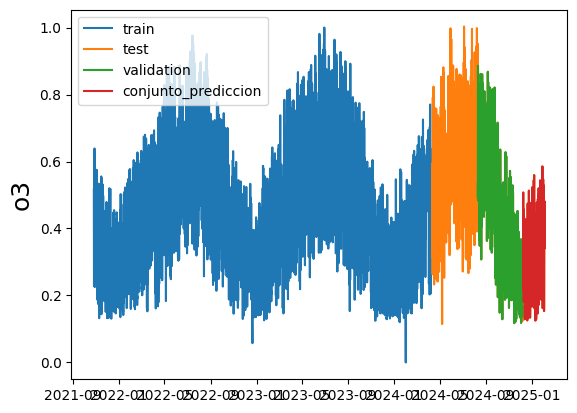

In [26]:
# Calculamos el indice correspondiente al 80% de los datos
index=int(o3.shape[0]*0.75)
index2=int(o3.shape[0]*0.85)
index3=int(o3.shape[0]*0.95)

# Dividimos el dataframe en train y test
o3_train=o3.iloc[:index] # Para entrenar
o3_test=o3.iloc[index:]  # Para testear 
o3_val=o3.iloc[index2:index3]  # Para evaluar rendimiento
o3_prediccion=o3.iloc[index3:] # Para predecir

# Normalizamos
def normalizacion(train, test,val):
    """
    Normaliza los datos de 'train' y 'test' utilizando los valores mínimos y máximos de 'train'.

    Args:
    train (pd.Series): Serie temporal de entrenamiento.
    test (pd.Series): Serie temporal de test.
    val (pd.Series): Serie temporal de validación.

    Returns:
    pd.Series: Serie temporal de entrenamiento normalizada.
    pd.Series: Serie temporal de test normalizada.
    """
    # Calculamos los valores mínimos y máximos de 'train'
    min_train = train.min()
    max_train = train.max()

    # Normalizamos 'train' y 'test' utilizando los valores de 'train'
    train_norm = (train - min_train) / (max_train - min_train)
    test_norm = (test - min_train) / (max_train - min_train)
    val_norm = (val - min_train) / (max_train - min_train)

    return train_norm, test_norm, val_norm, (min_train, max_train)

def normalizacion_inversa(vector, min_train, max_train):
    """
    Desnormaliza los datos de 'vector' utilizando los valores mínimos y máximos de 'train'.

    Args:
    vector (pd.Series): Serie temporal normalizada.
    min_train (float): Valor mínimo de 'train'.
    max_train (float): Valor máximo de 'train'.

    Returns:
    pd.Series: Serie temporal desnormalizada.
    """
    return vector * (max_train - min_train) + min_train

# Normalizamos
train, test, val, (min_train, max_train) = normalizacion(o3_train, o3_test,o3_val)

o3_prediccion= (o3_prediccion - min_train) / (max_train - min_train)

# # Procesamos
train=procesamiento(train)
test=procesamiento(test)
val=procesamiento(val)
pred=procesamiento(o3_prediccion)

plt.plot(train.index, train['o3'], label='train')
plt.plot(test.index, test['o3'], label='test')
plt.plot(val.index, val['o3'], label='validation')
plt.plot(pred.index, pred['o3'], label='conjunto_prediccion')
plt.ylabel('o3', fontsize=18)
plt.legend()
plt.show()

In [27]:
train.head()

,o3,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24f,x_next24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,,
2021-10-26 00:00:00,0.516147,0.571220,0.626293,0.633373,0.655403,0.645175,0.436718,-0.055073,0.022029,0.494118,0.396364,2021,10,1,0,2021-10-26
2021-10-26 01:00:00,0.468156,0.516147,0.571220,0.626293,0.633373,0.655403,0.437505,-0.047992,0.029897,0.438259,0.395119,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,0.426458,0.468156,0.516147,0.571220,0.626293,0.633373,0.438947,-0.041698,0.023603,0.402855,0.394135,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,0.372172,0.426458,0.468156,0.516147,0.571220,0.626293,0.439996,-0.054286,-0.003147,0.375319,0.394266,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,0.354863,0.372172,0.426458,0.468156,0.516147,0.571220,0.441340,-0.017309,-0.024389,0.379253,0.395283,2021,10,1,4,2021-10-26


Ya tenemos nuestro DF listo para pasarselo al modelo.

## 5. Modelado

Usamos el autoML de H2O

In [28]:
# Iniciamos sesion en H2O
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,2 hours 11 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 9 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.810 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


In [29]:
# Convertimos los datos a un objeto H2OFrame
train_h2o = h2o.H2OFrame(train,destination_frame="COCOR_LEPANTO_train")
test_h2o = h2o.H2OFrame(test,destination_frame="COCOR_LEPANTO_test")
val_h2o = h2o.H2OFrame(val,destination_frame="COCOR_LEPANTO_val")
prediccion_h2o = h2o.H2OFrame(pred,destination_frame="COCOR_LEPANTO_prediccion")

# Definimos variables dependientes e independientes
x = train_h2o.columns
y = 'o3'
x.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
from h2o.automl import H2OAutoML
# Definimos el modelo autoML
aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42,
                stopping_metric="RMSE",
                sort_metric="RMSE",
                keep_cross_validation_models=False,
                nfolds=0,
                project_name="COCOR_LEPANTO_aml_o3",
                stopping_rounds=0,
                stopping_tolerance=1e-4)
#Lo entrenamos
aml.train(x = x, 
          y = y,
          training_frame = train_h2o,
          leaderboard_frame = test_h2o)#,
          #validation_frame = val_h2o)

# guardamos el modelo en disco
model_path = h2o.save_model(model=aml.leader, path="COCOR_LEPANTO_model", force=True)

AutoML progress: |
10:36:56.858: Stopping tolerance set by the user is < 70% of the recommended default of 0.006838895902876788, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%


In [31]:
# Mostramos el leaderboard
lb = aml.leaderboard
print(lb.head(rows=lb.nrows))


model_id                                                    rmse          mse         mae       rmsle    mean_residual_deviance
GLM_1_AutoML_1_20250211_103656                        0.00246276  6.06519e-06  0.00126515  0.00158895               6.06519e-06
DeepLearning_grid_1_AutoML_1_20250211_103656_model_2  0.00308785  9.53479e-06  0.00258346  0.00203828               9.53479e-06
DeepLearning_1_AutoML_1_20250211_103656               0.00379694  1.44167e-05  0.00233333  0.00277394               1.44167e-05
DeepLearning_grid_2_AutoML_1_20250211_103656_model_1  0.00575479  3.31176e-05  0.00350995  0.00390379               3.31176e-05
GBM_grid_1_AutoML_1_20250211_103656_model_31          0.00589009  3.46932e-05  0.00153566  0.00392272               3.46932e-05
GBM_grid_1_AutoML_1_20250211_103656_model_25          0.0059557   3.54704e-05  0.00108216  0.00399798               3.54704e-05
GBM_grid_1_AutoML_1_20250211_103656_model_56          0.00612454  3.751e-05    0.00126205  0.00410822   

In [32]:
# Evaluar el rendimiento en el conjunto de validación
valid_performance = aml.leader.model_performance(val_h2o)
print("====================\nRendimiento en el conjunto de validación:\n")
print(valid_performance)
r2_valid = aml.leader.r2(valid=True)
print("R² en validación:", r2_valid)


# Evaluar el rendimiento en el conjunto de prueba
test_performance = aml.leader.model_performance(test_h2o)
print("====================\nRendimiento en el conjunto de prueba:\n")
print(test_performance)



# Evaluar el rendimiento en el conjunto de prueba
pred_performance = aml.leader.model_performance(prediccion_h2o)
print("====================\nRendimiento en el conjunto de prediccion:\n")
print(pred_performance)

Rendimiento en el conjunto de validación:

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 6.178873080014543e-06
RMSE: 0.0024857339117481062
MAE: 0.001203024810925771
RMSLE: 0.001561548996137794
Mean Residual Deviance: 6.178873080014543e-06
R^2: 0.9998097224744303
Null degrees of freedom: 2809
Residual degrees of freedom: 2794
Null deviance: 91.76349081978661
Residual deviance: 0.017362633354840864
AIC: -25695.758217292907
R² en validación: 0.9999246991905669
Rendimiento en el conjunto de prueba:

ModelMetricsRegressionGLM: glm
** Reported on test data. **

MSE: 6.065188374915346e-06
RMSE: 0.0024627603161727586
MAE: 0.0012651521935757033
RMSLE: 0.0015889531818151408
Mean Residual Deviance: 6.065188374915346e-06
R^2: 0.9998372902881603
Null degrees of freedom: 7095
Residual degrees of freedom: 7080
Null deviance: 269.59766765605355
Residual deviance: 0.04303857670839929
AIC: -65072.28174955631
Rendimiento en el conjunto de prediccion:

ModelMetricsRegressionGLM: glm
**

In [33]:
##################
# Predicciones 
##################

#realizamos las predicciones
predicted=aml.leader.predict(prediccion_h2o)


#Creamos una tabla comparativa y_true vs y_pred
df_result=pd.DataFrame()
df_result["y_true"]=pred['o3'].reset_index(drop=True)
df_result["y_pred"]=h2o.as_list(predicted,use_pandas=True)
df_result.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,0.215608,0.215636
1,0.233703,0.234573
2,0.272254,0.274418
3,0.308445,0.306608
4,0.344635,0.343228


# NO2

In [34]:
no2=df["no2"]
print(no2.head(24))

time_index
2021-10-25 01:00:00    41.0
2021-10-25 02:00:00    25.0
2021-10-25 03:00:00    17.0
2021-10-25 04:00:00    11.0
2021-10-25 05:00:00    10.0
2021-10-25 06:00:00    11.0
2021-10-25 07:00:00     9.0
2021-10-25 08:00:00    11.0
2021-10-25 09:00:00    17.0
2021-10-25 10:00:00    19.0
2021-10-25 11:00:00    14.0
2021-10-25 12:00:00    11.0
2021-10-25 13:00:00     9.0
2021-10-25 14:00:00     6.0
2021-10-25 15:00:00     6.0
2021-10-25 16:00:00     4.0
2021-10-25 17:00:00     3.0
2021-10-25 18:00:00     3.0
2021-10-25 19:00:00     5.0
2021-10-25 20:00:00    32.0
2021-10-25 21:00:00    48.0
2021-10-25 22:00:00    13.0
2021-10-25 23:00:00    49.0
2021-10-26 00:00:00    32.0
Name: no2, dtype: float64


Resample por Semanas:
 time_index
2021-10-25    16.260870
2021-10-26    24.583333
2021-10-27    22.125000
2021-10-28    21.708333
2021-10-29    21.291667
Freq: D, Name: no2, dtype: float64
Media Deslizante 3dias (aprox):
 time_index
2021-10-25 01:00:00   NaN
2021-10-25 02:00:00   NaN
2021-10-25 03:00:00   NaN
2021-10-25 04:00:00   NaN
2021-10-25 05:00:00   NaN
2021-10-25 06:00:00   NaN
2021-10-25 07:00:00   NaN
2021-10-25 08:00:00   NaN
2021-10-25 09:00:00   NaN
2021-10-25 10:00:00   NaN
Name: no2, dtype: float64


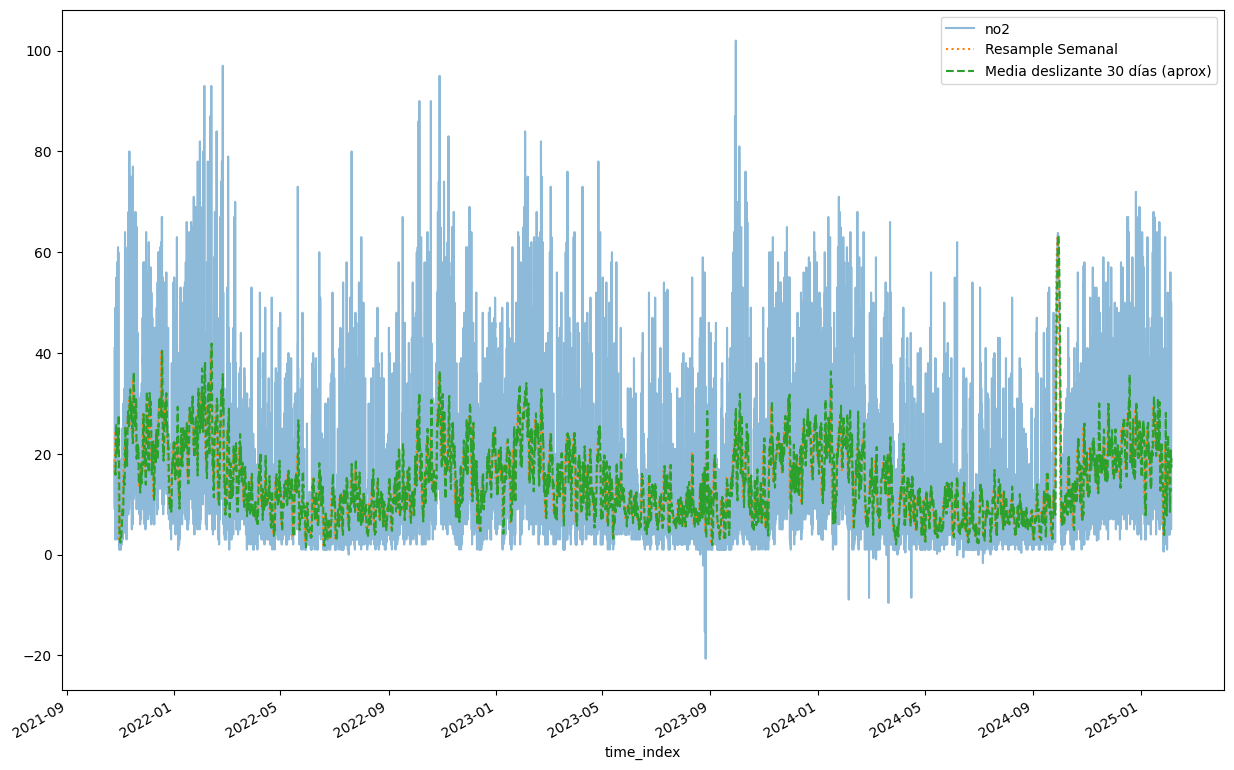

In [35]:
no2_resample = no2.resample('D').mean()
print("Resample por Semanas:\n",no2_resample.head())

no2_roll = no2.rolling(window=24).mean()
print("Media Deslizante 3dias (aprox):\n", no2_roll.head(10))

# Visualizamos los datos resampleados con su media deslizante
ax=no2.plot(alpha=0.5, style='-',figsize=(15,10)) #guardamos los ejes para reutilizarlos
no2_resample.plot(style=':', ax=ax, label='Resample Semanal')
no2_roll.plot(style='--', ax=ax, label='Media deslizante 30 días (aprox)')
ax.legend();


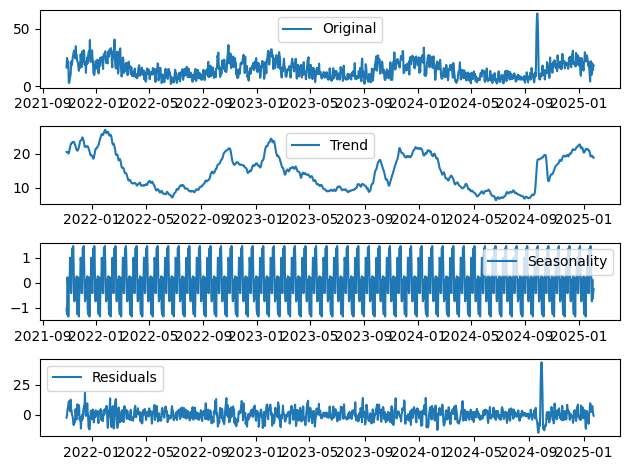

In [36]:
###############################################
# TENDENCIA - ESTACIONALIDAD - RESIDUOS
###############################################



from statsmodels.tsa.seasonal import seasonal_decompose
x = no2_resample
x.interpolate(method="linear", order=2, inplace=True)
x.index = pd.to_datetime(x.index)
x = x.astype(float) # force float
x=x.asfreq('D')  # PONER AQUI MISMA FRECUENCIA QUE EN RESAMPLE
period=24



decomposition = seasonal_decompose(x,period=period)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

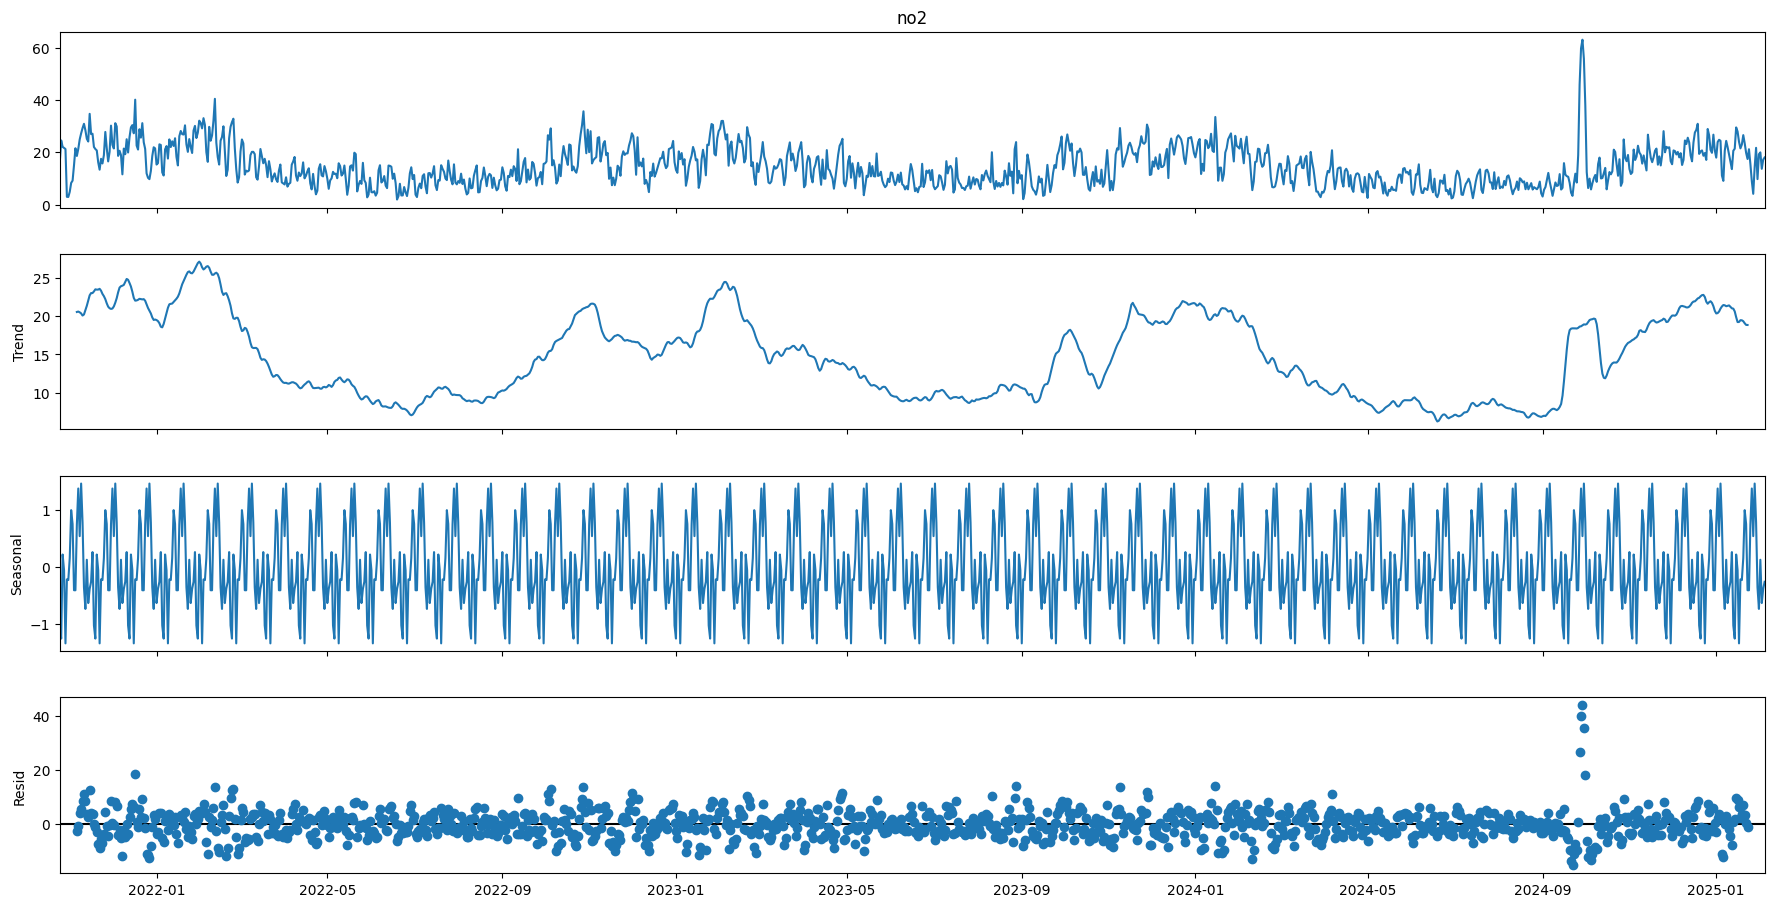

In [37]:
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

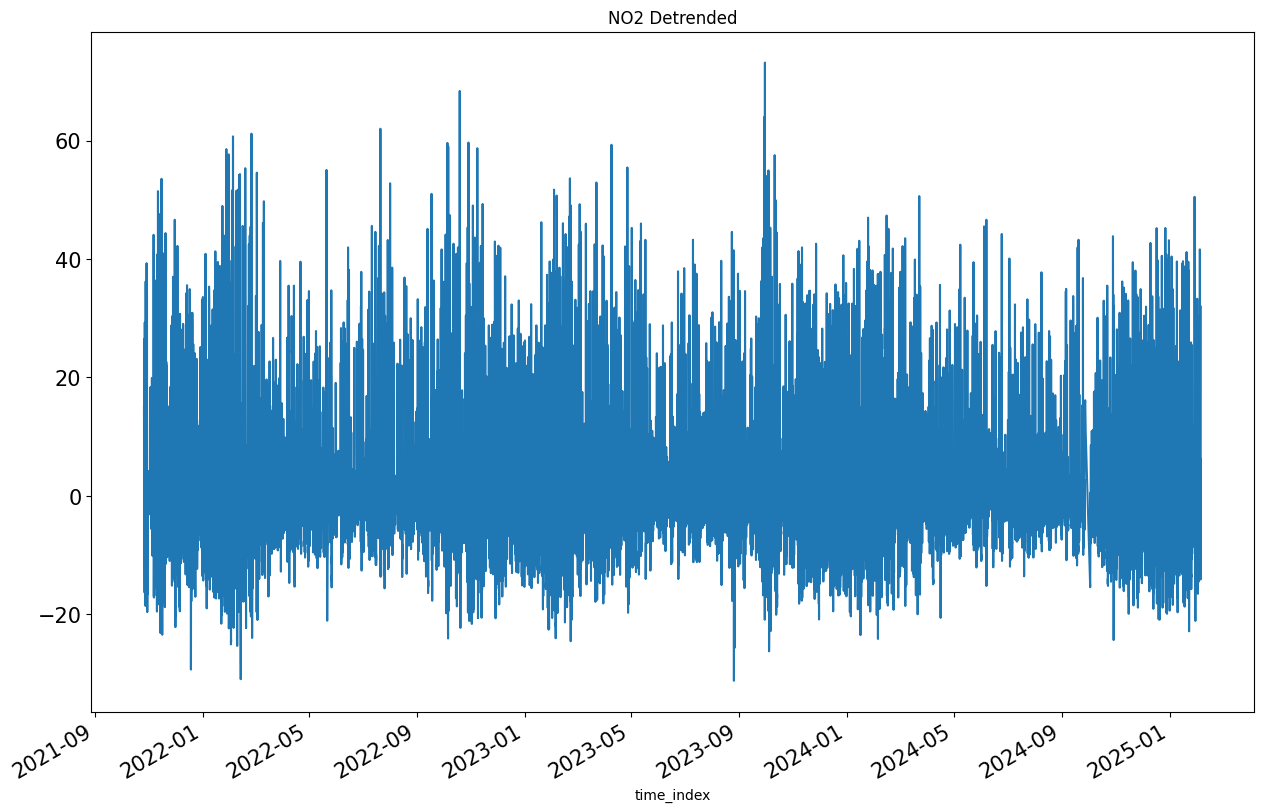

In [38]:
################################
# Eliminamos tendencia de la serie
################################

no2_roll=no2.rolling(24).mean()
no2_detrended = no2 - no2_roll
#dibujamos
no2_detrended.plot(figsize=(15,10),linewidth=1.5,fontsize=15, title='NO2 Detrended')
plt.show()


## ADF Test


> https://es.wikipedia.org/wiki/Prueba_de_Dickey-Fuller_aumentada

> https://www.linkedin.com/advice/0/how-do-you-interpret-results-augmented-dickey-fuller?lang=es&lang=es&originalSubdomain=es

 > ¿Es estacionaria la serie Original?
Estadístico = -11.255
P-value = 0.000
Valores críticos :
	1%: -3.4305793088592944 - La serie es  estacionaria con una confianza de 99%
	5%: -2.86164134812435 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5668239445474152 - La serie es  estacionaria con una confianza de 90%


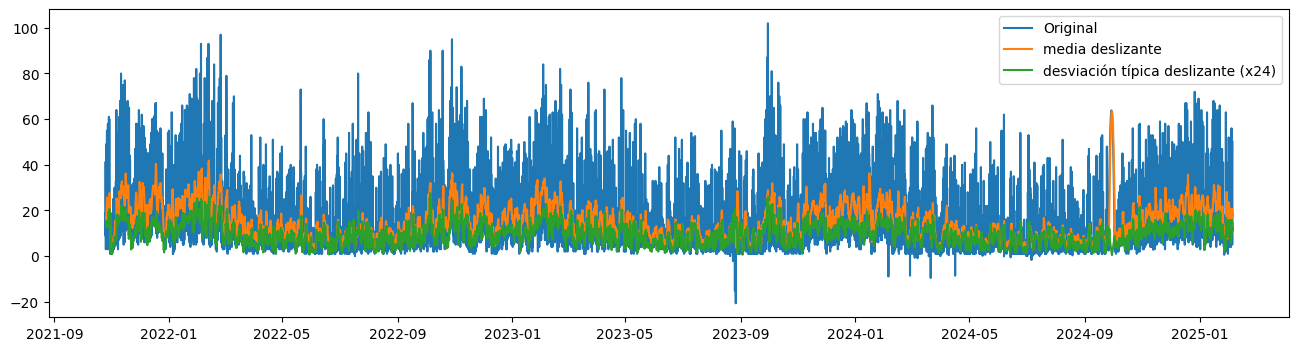

In [39]:
# Original
ADF_test(no2, "Original")
test_stationarity(no2, "Original")


 > ¿Es estacionaria la serie Detrended?
Estadístico = -28.622
P-value = 0.000
Valores críticos :
	1%: -3.430579493951724 - La serie es  estacionaria con una confianza de 99%
	5%: -2.8616414299268818 - La serie es  estacionaria con una confianza de 95%
	10%: -2.5668239880889843 - La serie es  estacionaria con una confianza de 90%


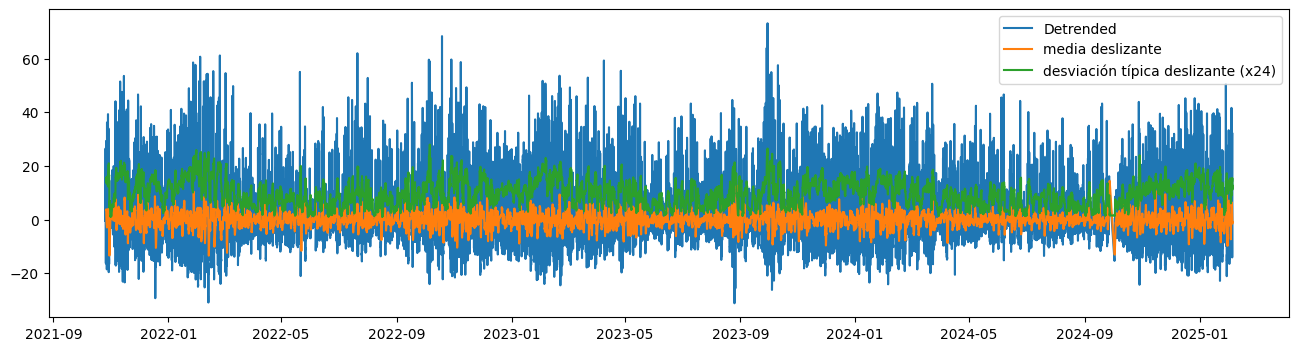

In [40]:
# Sin TENDENCIA
#
no2_de=(no2 - no2.rolling(window=24).mean())
ADF_test(no2_de, "Detrended")
test_stationarity(no2_de, "Detrended")


## 3. Preprocesamiento



In [41]:
no2_final=no2.copy()
no2_final=procesamiento(no2_final)
no2_final.head()


,no2,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24f,x_next24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,,
2021-10-26 00:00:00,32.0,49.0,13.0,48.0,32.0,5.0,16.916667,-17.0,0.0,32.0,24.583333,2021,10,1,0,2021-10-26
2021-10-26 01:00:00,23.0,32.0,49.0,13.0,48.0,32.0,16.166667,-9.0,-19.0,42.0,25.375000,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,17.0,23.0,32.0,49.0,13.0,48.0,15.833333,-6.0,-1.0,18.0,25.416667,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,25.0,17.0,23.0,32.0,49.0,13.0,16.166667,8.0,12.0,13.0,24.916667,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,16.0,25.0,17.0,23.0,32.0,49.0,16.375000,-9.0,4.0,12.0,24.750000,2021,10,1,4,2021-10-26


## 4. Split y Normalización


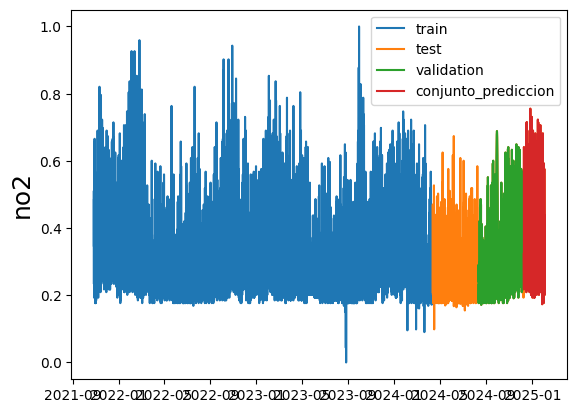

In [42]:
no2_train=no2_final.iloc[:index] # Para entrenar
no2_test=no2_final.iloc[index:]  # Para testear
no2_val=no2_final.iloc[index2:index3]  # Para evaluar rendimiento
no2_prediccion=no2_final.iloc[index3:] # Para predecir

#normalizamos
no2_train, no2_test, no2_val, (no2_min_train, no2_max_train) = normalizacion(no2_train['no2'], no2_test['no2'],no2_val['no2'])

no2_prediccion= (no2_prediccion['no2'] - no2_min_train) / (no2_max_train - no2_min_train)

#procesamos
no2_train=procesamiento(no2_train)
no2_test=procesamiento(no2_test)
no2_val=procesamiento(no2_val)
no2_prediccion=procesamiento(no2_prediccion)

plt.plot(no2_train.index, no2_train['no2'], label='train')
plt.plot(no2_test.index, no2_test['no2'], label='test')
plt.plot(no2_val.index, no2_val['no2'], label='validation')
plt.plot(no2_prediccion.index, no2_prediccion['no2'], label='conjunto_prediccion')
plt.ylabel('no2', fontsize=18)
plt.legend()
plt.show()


In [43]:
no2_train.head()

,no2,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24f,x_next24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,,
2021-10-26 23:00:00,0.347795,0.616829,0.323337,0.592372,0.315184,0.282574,0.368855,-0.269035,-0.065221,0.413015,0.348814,2021,10,1,23,2021-10-26
2021-10-27 00:00:00,0.429320,0.347795,0.616829,0.323337,0.592372,0.315184,0.368855,0.081526,0.130441,0.298879,0.343379,2021,10,2,0,2021-10-27
2021-10-27 01:00:00,0.510846,0.429320,0.347795,0.616829,0.323337,0.592372,0.375310,0.081526,0.211967,0.298879,0.334547,2021,10,2,1,2021-10-27
2021-10-27 02:00:00,0.315184,0.510846,0.429320,0.347795,0.616829,0.323337,0.375649,-0.195662,0.032610,0.282574,0.333188,2021,10,2,2,2021-10-27
2021-10-27 03:00:00,0.274421,0.315184,0.510846,0.429320,0.347795,0.616829,0.371573,-0.040763,-0.040763,0.315184,0.334886,2021,10,2,3,2021-10-27


## 5. Modelado


In [44]:
# convertimos los datos a un objeto H2OFrame
no2_train_h2o = h2o.H2OFrame(no2_train,destination_frame="COCOR_LEPANTO_train_no2")
no2_test_h2o = h2o.H2OFrame(no2_test,destination_frame="COCOR_LEPANTO_test_no2")
no2_val_h2o = h2o.H2OFrame(no2_val,destination_frame="COCOR_LEPANTO_val_no2")
no2_prediccion_h2o = h2o.H2OFrame(no2_prediccion,destination_frame="COCOR_LEPANTO_prediccion_no2")

# Definimos variables dependientes e independientes
x = no2_train_h2o.columns
y = 'no2'
x.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
# Definimos el modelo
aml_no2 = H2OAutoML(max_runtime_secs = 3600,
                seed = 42,
                stopping_metric="RMSE",
                sort_metric="RMSE",
                keep_cross_validation_models=False,
                nfolds=0,
                project_name="COCOR_LEPANTO_aml_no2",
                stopping_rounds=2,
                stopping_tolerance=1e-4)
# Lo entrenamos
aml_no2.train(x = x, 
          y = y,
          training_frame = no2_train_h2o,
          leaderboard_frame = no2_test_h2o,
          validation_frame = no2_val_h2o)

# Guardamos el modelo en disco
model_path_no2 = h2o.save_model(model=aml_no2.leader, path="COCOR_LEPANTO_model_no2", force=True)



AutoML progress: |
10:47:17.901: Stopping tolerance set by the user is < 70% of the recommended default of 0.006838895902876788, so models may take a long time to converge or may not converge at all.

████████████████████████████████████████████████████████

In [1]:
# Mostramos el leaderboard
lb_no2 = aml_no2.leaderboard
print(lb_no2.head(rows=lb_no2.nrows))

NameError: name 'aml_no2' is not defined

In [ ]:
# Evaluar el rendimiento en el conjunto de validación
valid_performance_no2 = aml_no2.leader.model_performance(no2_val_h2o)
print("Rendimiento en el conjunto de validación:")
print(valid_performance_no2)

# Evaluar el rendimiento en el conjunto de prueba
test_performance_no2 = aml_no2.leader.model_performance(no2_test_h2o)
print("Rendimiento en el conjunto de prueba:")
print(test_performance_no2)


In [ ]:
##################
# Predicciones 
##################

#realizamos las predicciones
predicted_no2=aml_no2.leader.predict(no2_prediccion_h2o)


#Creamos una tabla comparativa y_true vs y_pred
df_result=pd.DataFrame()
df_result["y_true"]=no2_prediccion['no2'].reset_index(drop=True)
df_result["y_pred"]=h2o.as_list(predicted_no2,use_pandas=True)
df_result.head()

In [ ]:
from scipy import stats

# Calculamos el R² en el conjunto de prediccion
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_result['y_pred'],y=df_result['y_true'])
print('R2 = ',r_value*r_value)

# SO2

In [2]:
so2= df["so2"]
print(so2.head(24))

NameError: name 'df' is not defined

In [ ]:
so2_resample = so2.resample('D').mean()
print("Resample por Semanas:\n",so2_resample.head())

so2_roll = so2.rolling(window=24).mean()
print("Media Deslizante 3dias (aprox):\n", so2_roll.head(10))

# Visualizamos los datos resampleados con su media deslizante
ax=so2.plot(alpha=0.5, style='-',figsize=(15,10)) #guardamos los ejes para reutilizarlos
so2_resample.plot(style=':', ax=ax, label='Resample Semanal')
so2_roll.plot(style='--', ax=ax, label='Media deslizante 30 días (aprox)')
ax.legend();


In [ ]:
###############################################
# TENDENCIA - ESTACIONALIDAD - RESIDUOS
###############################################



from statsmodels.tsa.seasonal import seasonal_decompose
x = so2_resample
x.interpolate(method="linear", order=2, inplace=True)
x.index = pd.to_datetime(x.index)
x = x.astype(float) # force float
x=x.asfreq('D')  # PONER AQUI MISMA FRECUENCIA QUE EN RESAMPLE
period=24



decomposition = seasonal_decompose(x,period=period)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(x, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
fig = decomposition.plot()
fig.set_size_inches(20,10)
plt.show()

In [ ]:
##########
# Eliminamos tendencia de la serie
##########

so2_roll=so2.rolling(24).mean()
so2_detrended = so2 - so2_roll
#dibujamos
so2_detrended.plot(figsize=(15,10),linewidth=1.5,fontsize=15, title='SO2 Detrended')
plt.show()


## ADF Test

In [ ]:
#Original
ADF_test(so2, "Original")
test_stationarity(so2, "Original")

In [ ]:
# Sin Tendencia
#
so2_de=(so2 - so2.rolling(window=24).mean())
ADF_test(so2_de, "Detrended")
test_stationarity(so2_de, "Detrended")


## Preprocesamiento

In [ ]:
so2_final=so2.copy().to_frame()
so2_final=procesamiento(so2_final)
so2_final.head()

so2_train=so2_final.iloc[:index] # Para entrenar
so2_test=so2_final.iloc[index:]  # Para testear
so2_val=so2_final.iloc[index2:index3]  # Para evaluar rendimiento
so2_prediccion=so2_final.iloc[index3:] # Para predecir

#normalizamos
so2_train, so2_test, so2_val, (so2_min_train, so2_max_train) = normalizacion(so2_train['so2'], so2_test['so2'],so2_val['so2'])

so2_prediccion= (so2_prediccion['so2'] - so2_min_train) / (so2_max_train - so2_min_train)

#procesamos
so2_train=procesamiento(so2_train)
so2_test=procesamiento(so2_test)
so2_val=procesamiento(so2_val)
so2_prediccion=procesamiento(so2_prediccion)

plt.plot(so2_train.index, so2_train['so2'], label='train')
plt.plot(so2_test.index, so2_test['so2'], label='test')
plt.plot(so2_val.index, so2_val['so2'], label='validation')
plt.plot(so2_prediccion.index, so2_prediccion['so2'], label='conjunto_prediccion')
plt.ylabel('so2', fontsize=18)
plt.legend()
plt.show()


In [ ]:
so2_train.head()

## Modelado

In [ ]:
# Convertimos los datos a un objeto H2OFrame
so2_train_h2o = h2o.H2OFrame(so2_train,destination_frame="COCOR_LEPANTO_train_so2")
so2_test_h2o = h2o.H2OFrame(so2_test,destination_frame="COCOR_LEPANTO_test_so2")
so2_val_h2o = h2o.H2OFrame(so2_val,destination_frame="COCOR_LEPANTO_val_so2")
so2_prediccion_h2o = h2o.H2OFrame(so2_prediccion,destination_frame="COCOR_LEPANTO_prediccion_so2")

# Definimos variables dependientes e independientes
x = so2_train_h2o.columns
y = 'so2'
x.remove(y)


In [ ]:
# Definimos el modelo
aml_so2 = H2OAutoML(max_runtime_secs = 3600,
                seed = 42,
                stopping_metric="RMSE",
                sort_metric="RMSE",
                keep_cross_validation_models=False,
                project_name="COCOR_LEPANTO_aml_so2",
                stopping_rounds=5,
                exclude_algos=["DeepLearning"],  # Excluir algoritmos propensos a sobreajustar
                stopping_tolerance=1e-4)

# Lo entrenamos
aml_so2.train(x = x, 
          y = y,
          training_frame = so2_train_h2o,
          leaderboard_frame = so2_test_h2o,
          validation_frame = so2_val_h2o)

# Guardamos el modelo en disco
model_path_so2 = h2o.save_model(model=aml_so2.leader, path="COCOR_LEPANTO_model_so2", force=True)


In [ ]:
# Mostramos el leaderboard
lb_so2 = aml_so2.leaderboard
print(lb_so2.head(rows=lb_so2.nrows))


In [ ]:
# Evaluar el rendimiento en el conjunto de validación
valid_performance_so2 = aml_so2.leader.model_performance(so2_val_h2o)
print("Rendimiento en el conjunto de validación:")
print(valid_performance_so2)

# Evaluar el rendimiento en el conjunto de prueba
test_performance_so2 = aml_so2.leader.model_performance(so2_test_h2o)
print("Rendimiento en el conjunto de prueba:")
print(test_performance_so2)


In [ ]:
####################
# predicciones
####################



# PM10 y PM25

**TAREA:** Crear modelo predictivo (autoML) para predecir valores futuros de PM10 y PM25

**Observaciones:**
* Ambas variables tienen correlación como se ha visto anteriormente, por tanto se podría usar el mismo dataframe para entrenar ambos modelos. (1 Dataframe, 2 Modelos distintos)
* No te limites a copiar y pegar código, tomatelo como una primera práctica de aproximación a la Ciencia de Datos, estructura tu Dataframe correctamente, añade explicaciones del por qué de tus decisiones, etc.